In [32]:
%reload_ext autoreload
%autoreload 2

from transformers import (
    BitsAndBytesConfig,
    LlavaNextProcessor,
    LlavaNextForConditionalGeneration
)
import torch
import pandas as pd
import re
import gc
import numpy as np
from tqdm import tqdm
import os
from pathlib import Path
import matplotlib.pyplot as plt

from test_MLLMs import run_vlm_evaluation
from making_color_images.model_priors import TorchColorPriors, GPTColorPriors
from making_color_images.plot_variants import collect_variants_for, show_variants_grid, plot_vlm_performance, variant_label
from making_color_images.recolor_images import generate_variants, resize_all_images_and_masks


os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

fontsize = 14

In [2]:
# Base data folder
WORK = Path(os.environ.get("WORK", Path.cwd()))
DATA = WORK / "color-concept-entanglement" / "data"

FRUIT = DATA / "fruit"
OUTLINES = DATA / "color_images"

## Load Model

In [3]:
# Set a specific seed for reproducibility
SEED = 42
rng = np.random.default_rng(SEED)

# Setting the seed for PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If using GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    llm_int8_enable_fp32_cpu_offload=True
)

torch.cuda.empty_cache()
gc.collect()

model_name = "llava-v1.6-mistral-7b-hf"
processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")
model = LlavaNextForConditionalGeneration.from_pretrained(
    "llava-hf/llava-v1.6-mistral-7b-hf", dtype=torch.float16, low_cpu_mem_usage=True, device_map="auto", quantization_config=bnb_config
).to(device)

Using device: cuda


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## 1. Simple Fruit Dataset

In [4]:
# Simple fruit dataset
evaluate_fruit = False
df = pd.read_parquet(FRUIT/ "fruit_images.parquet")

if evaluate_fruit:
    df_results = run_vlm_evaluation(
        df,
        processor,
        model,
        device,
        mode="both"
    )
    
    display(df_results)
    out_path = FRUIT / "outline_results.csv"
    df.to_csv(out_path, index=False)
elif (FRUIT / "outline_results.csv").exists():
    fruit_df = pd.read_csv(FRUIT / "results_llava-next_both.csv")
    display(fruit_df)

,object,image_type,image_path,pred_color_most,pred_color_this
0,banana,grayscale,data/fruit/banana1.jpeg,yellow,yellow
1,banana,background,data/fruit/banana1_background.jpeg,yellow,white
2,banana,color,data/fruit/banana1_color.jpeg,yellow,yellow
3,banana,grayscale,data/fruit/banana2.jpeg,yellow,black
4,banana,background,data/fruit/banana2_background.jpeg,yellow,white
5,banana,color,data/fruit/banana2_color.jpeg,yellow,yellow
6,blueberry,grayscale,data/fruit/blueberry.jpeg,white,white
7,blueberry,background,data/fruit/blueberry_background.jpeg,white,white
8,blueberry,color,data/fruit/blueberry_color.jpeg,blue,blue
9,cucumber,grayscale,data/fruit/cucumber.jpeg,green,white


## 2. Outline Image Dataset 

## 2.1. Query world-knowledge color priors

In [4]:
# Load dataframe with outline images and masks
df = pd.read_csv(DATA / "segmented_images.csv")
display(df)

,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response,score,watermark,num_objects,cv_mask_path,sam_mask_path
0,['yellow'],purple,sunflower,https://thumbs.dreamstime.com/b/black-outline-...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
1,"['brown', 'black', 'orange']",green,tabby,https://img.recraft.ai/5P-WlUIGI2MwJC2v_JyrGkp...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
2,"['pink', 'white']",green,spoonbill,https://img.freepik.com/premium-vector/drawing...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
3,['white'],green,Samoyed,https://img.freepik.com/premium-photo/black-wh...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
4,"['grey', 'black']",red,Norwegian elkhound,https://t3.ftcdn.net/jpg/16/85/30/00/360_F_168...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
...,...,...,...,...,...,...,...,...,...,...,...
215,"['gold', 'silver']",green,crown,https://i.pinimg.com/736x/32/52/35/325235d85fb...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",42.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
216,"['orange', 'white']",purple,pill bottle,https://media.istockphoto.com/id/470313936/vec...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",35.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
217,['black'],pink,dial telephone,https://png.pngtree.com/png-clipart/20230811/o...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",35.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
218,['black'],pink,digital watch,https://img.freepik.com/premium-vector/digital...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",34.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...


In [5]:
# Initalize ModelColorPriors
priors = TorchColorPriors(
    processor=processor,
    model=model,
    data_folder=DATA,
    device=device
)

In [7]:
# Generate new priors
# priors_df = priors.get_model_color_priors(df, save=True)

In [6]:
# Checkpoint: display the generated priors
priors_df = priors.load_model_priors()
display(priors_df[['object', 'correct_answer', 'dummy_priors', 'image_priors']])

,object,correct_answer,dummy_priors,image_priors
0,sunflower,[yellow],"[yellow, brown, green]","[yellow, black, white]"
1,tabby,"[brown, black, orange]","[black, grey, white]","[black, grey, white]"
2,spoonbill,"[pink, white]","[pink, white, black]","[white, black, grey]"
3,Samoyed,[white],"[white, cream, light brown]","[white, cream, light grey]"
4,Norwegian elkhound,"[grey, black]","[grey, black, brown]","[white, grey, black]"
...,...,...,...,...
215,crown,"[gold, silver]","[gold, silver, white]","[gold, silver, black]"
216,pill bottle,"[orange, white]","[blue, white, green]","[white, blue, green]"
217,dial telephone,[black],"[black, white, grey]","[black, white, grey]"
218,digital watch,[black],"[black, grey, blue]","[black, silver, white]"


In [7]:
# Pick a primary color prior, overwrite correct_answer, and drop all rows where the prior is None
priors_df["prior"], priors_df["prior_changed"] = priors.pick_primary_color(priors_df)

[NULL] Samoyed: all priors invalid ['white', 'cream', 'light brown'] to NaN
[INFO] hare: replaced 'white' with 'black'
[INFO] golf ball: replaced 'white' with 'yellow'
[INFO] French horn: replaced 'silver' with 'black'
[INFO] washer: replaced 'white' with 'grey'
[INFO] bathtub: replaced 'white' with 'blue'
[INFO] screw: replaced 'silver' with 'black'
[INFO] saxophone: replaced 'silver' with 'black'
[NULL] bagel: all priors invalid ['plain', 'wheat', 'sesame'] to NaN
[INFO] airliner: replaced 'white' with 'blue'
[INFO] owl: replaced 'white' with 'grey'
[INFO] paper towel: replaced 'white' with 'grey'
[INFO] pigeon: replaced 'white' with 'grey'
[INFO] boat: replaced 'white' with 'blue'
[INFO] ptarmigan: replaced 'white' with 'black'
[INFO] garlic: replaced 'white' with 'purple'
[INFO] great white shark: replaced 'white' with 'grey'
[INFO] faucet: replaced 'silver' with 'black'
[INFO] dove: replaced 'white' with 'grey'
[INFO] daisy: replaced 'white' with 'yellow'
[INFO] van: replaced 'whi

In [8]:
print(f"Number of objects with valid model color priors: {len(priors_df['prior'].dropna())}")
print(f"Number of objects where the original prior was changed to be valid: {priors_df['prior_changed'].sum()}")
df["correct_answer"] = priors_df["prior"]

df.dropna(subset=["correct_answer"], axis=0, inplace=True)

#priors.analyze_differences(priors_df)
display(priors_df)
df["correct_answer"].value_counts()

Number of objects with valid model color priors: 215
Number of objects where the original prior was changed to be valid: 46


,object,correct_answer,dummy_priors,image_priors,prior,prior_changed
0,sunflower,[yellow],"[yellow, brown, green]","[yellow, black, white]",yellow,False
1,tabby,"[brown, black, orange]","[black, grey, white]","[black, grey, white]",black,False
2,spoonbill,"[pink, white]","[pink, white, black]","[white, black, grey]",pink,False
3,Samoyed,[white],"[white, cream, light brown]","[white, cream, light grey]",None,True
4,Norwegian elkhound,"[grey, black]","[grey, black, brown]","[white, grey, black]",grey,False
...,...,...,...,...,...,...
215,crown,"[gold, silver]","[gold, silver, white]","[gold, silver, black]",None,True
216,pill bottle,"[orange, white]","[blue, white, green]","[white, blue, green]",blue,False
217,dial telephone,[black],"[black, white, grey]","[black, white, grey]",black,False
218,digital watch,[black],"[black, grey, blue]","[black, silver, white]",black,False


correct_answer
black     89
red       35
green     23
brown     18
grey      16
yellow    12
blue      10
orange     8
pink       2
purple     2
Name: count, dtype: int64

## 2.2. Resize images and masks

In [15]:
RESIZED_IMGS = DATA / "resized_images"
RESIZED_MASKS = DATA / "resized_cv_masks"
RESIZED_IMGS.mkdir(parents=True, exist_ok=True)
RESIZED_MASKS.mkdir(parents=True, exist_ok=True)

df = resize_all_images_and_masks(
    df,
    img_out_folder=RESIZED_IMGS,
    mask_out_folder=RESIZED_MASKS,
    target_size=512,              # or 256, 384, 1024
    mask_column="cv_mask_path",   
    img_column="image_path"
)


Resizing all: 100%|██████████| 215/215 [00:12<00:00, 17.04it/s]

Resized 215 images.


## 2.3. Recolor outline images with model prior

In [13]:
# Define custom grid for coloring
pct_schedule = list(range(0, 11, 1)) + list(range(20, 110, 10))
print(pct_schedule)

# Set coloring modes
coloring_modes = ["sequential"] #, "independent"]

DUMMY = True  # Set to True to use dummy priors, False for image priors
suffix = "dummy_prior" if DUMMY else "image_prior"
OUT_COLOR = OUTLINES / model_name / suffix
OUT_COLOR.mkdir(parents=True, exist_ok=True)   

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [ ]:
# Generate variants for all images in d
for _, row in tqdm(df.iterrows(), total=len(df), desc="Generating color variants"):
    for color_mode in coloring_modes:
        paths = generate_variants(
            row=row,
            target_color=row['correct_answer'],
            out_dir=OUT_COLOR,
            rng=rng,
            use_patches=True,
            patch_size=16,
            step_size=10,
            mode=color_mode,
            pct_schedule=pct_schedule
        )

Generating color variants: 100%|██████████| 215/215 [25:08<00:00,  7.01s/it]


In [10]:
# Define which range of image variants to plot
tail_range = list(range(0, 6)) + list(range(95, 101))
ten_increase = list(range(0, 110, 10))
compact = [0, 10, 50, 90, 100]

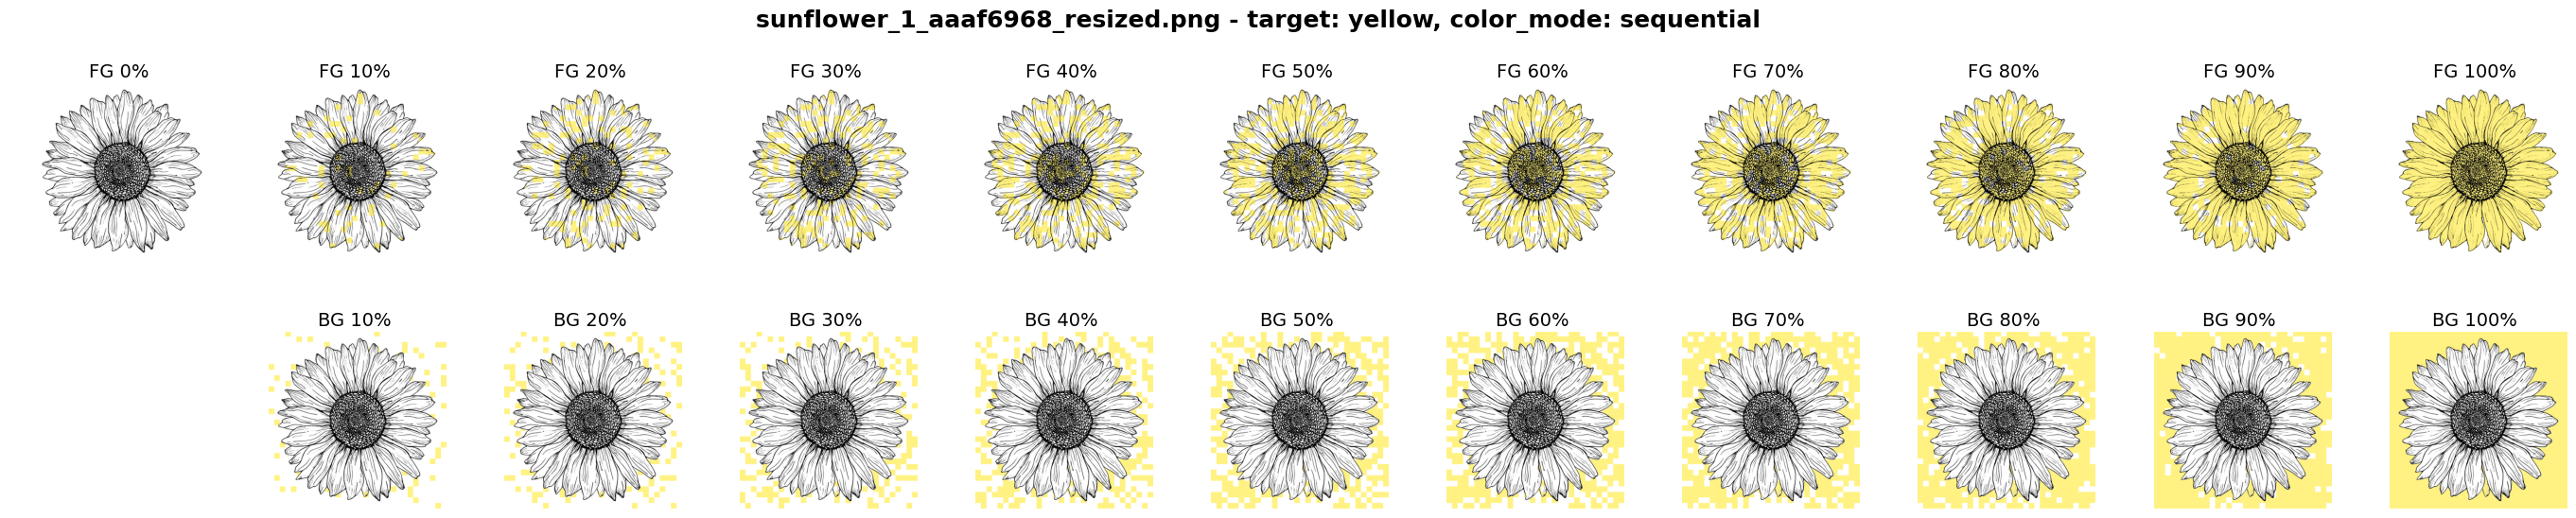

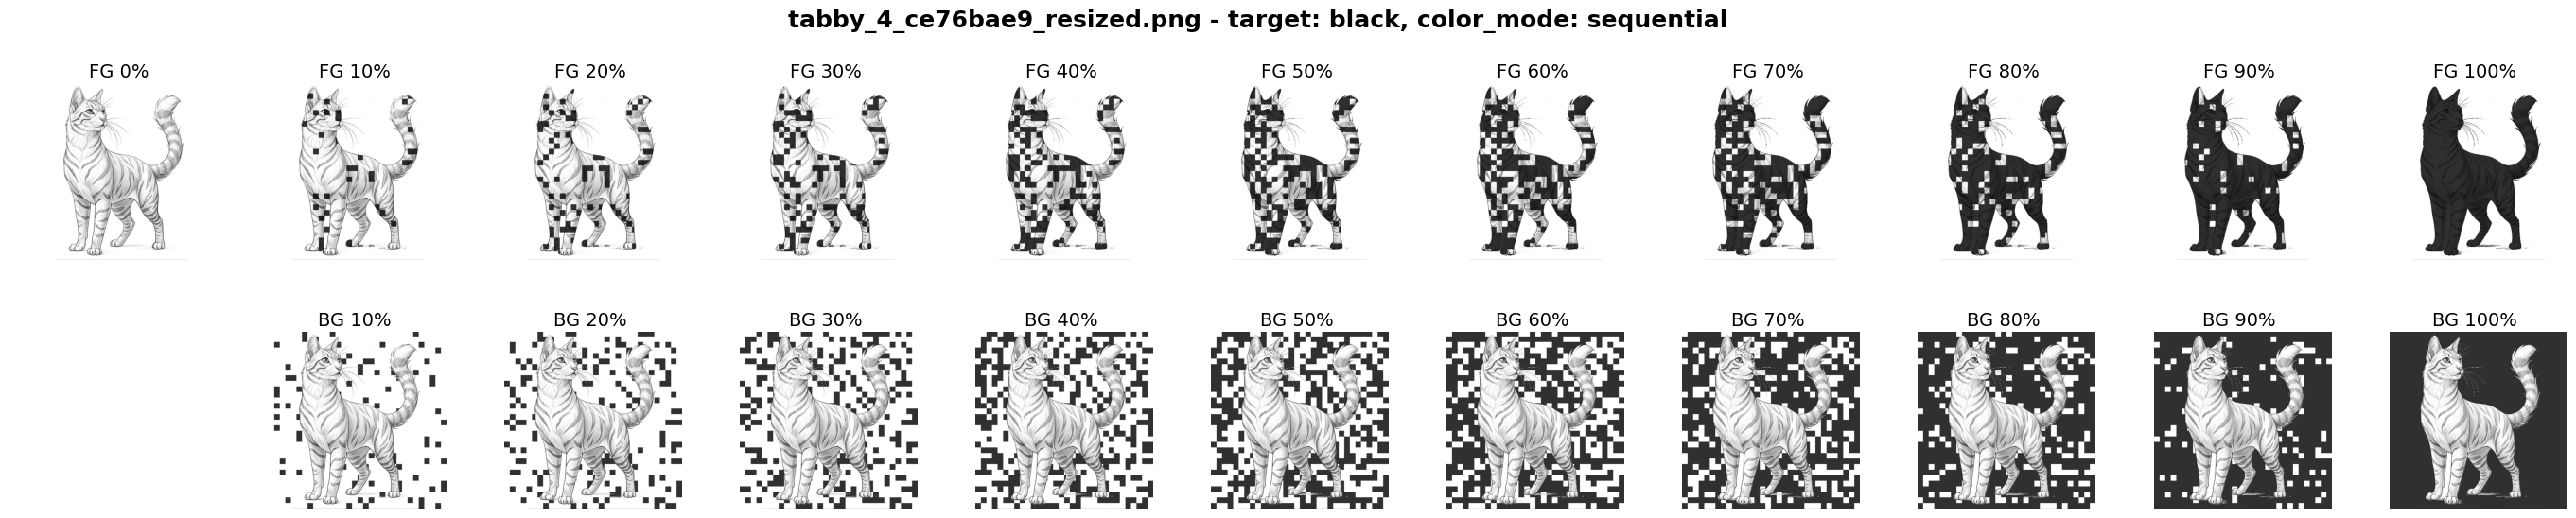

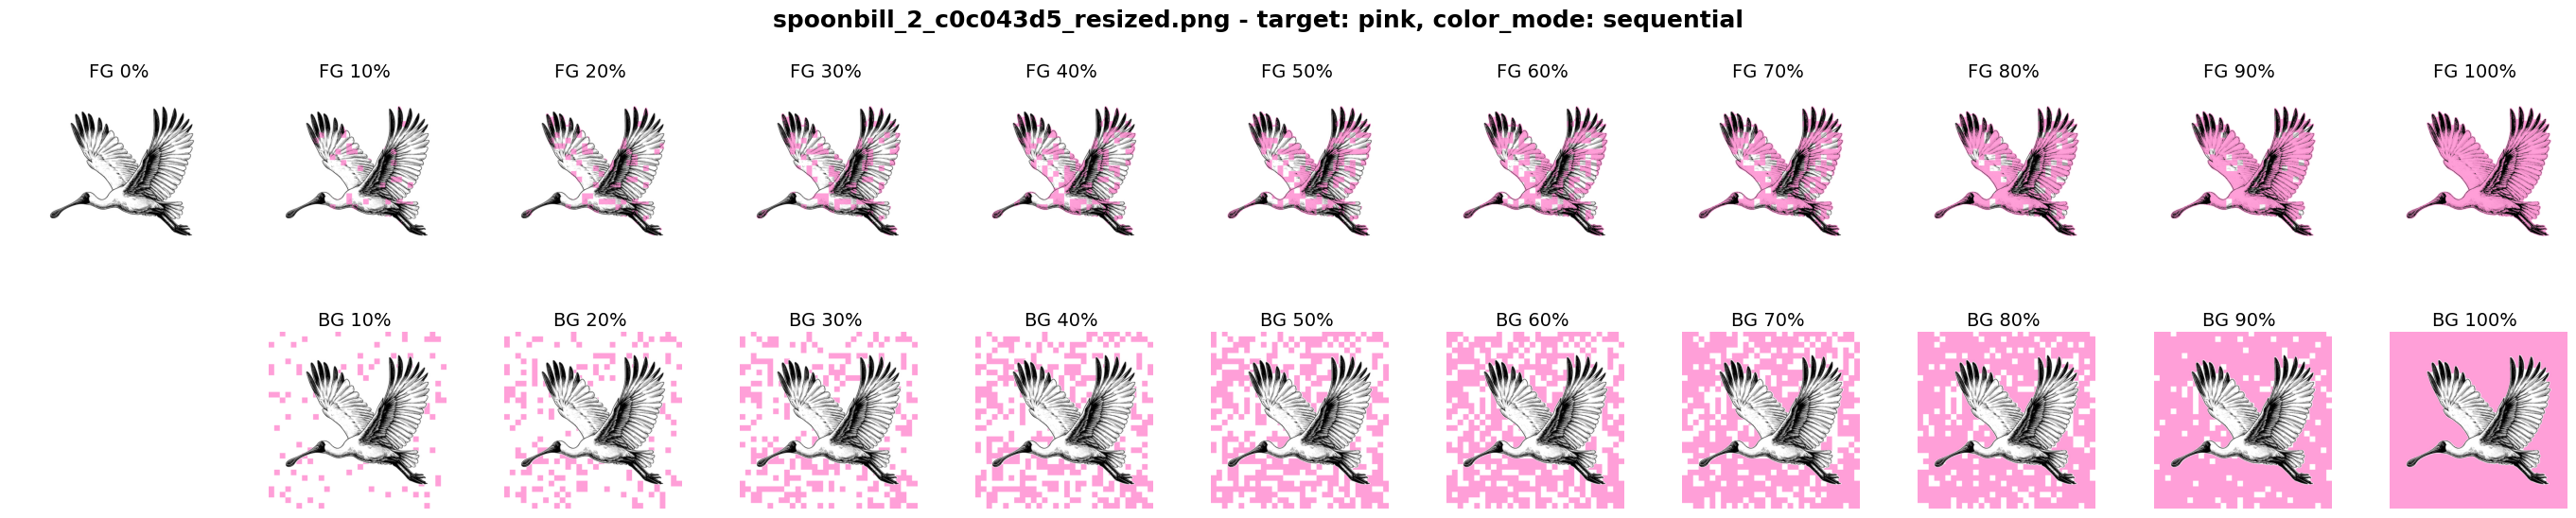

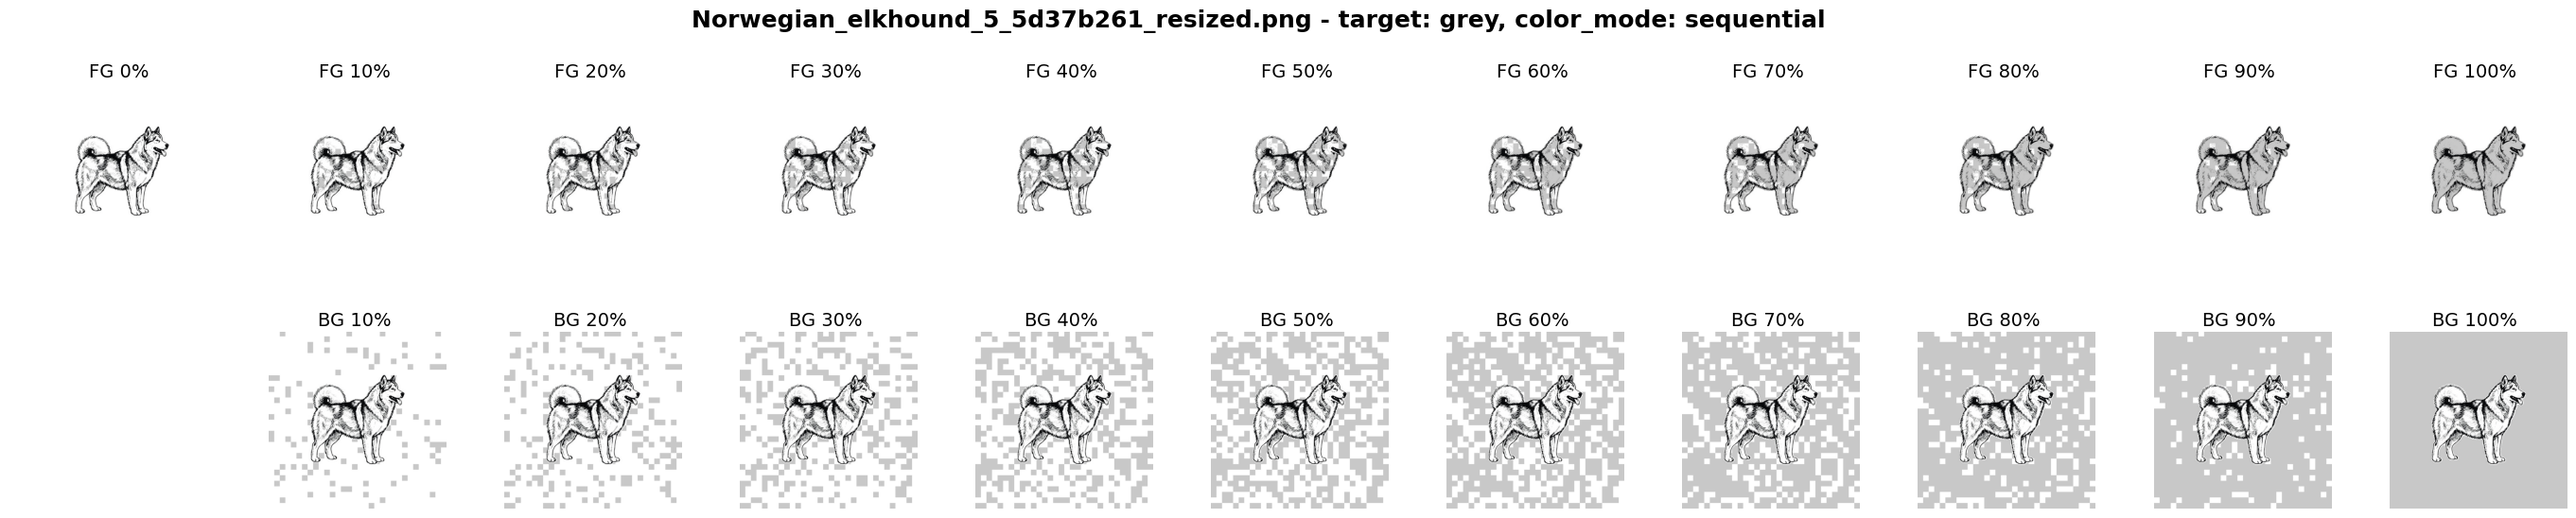

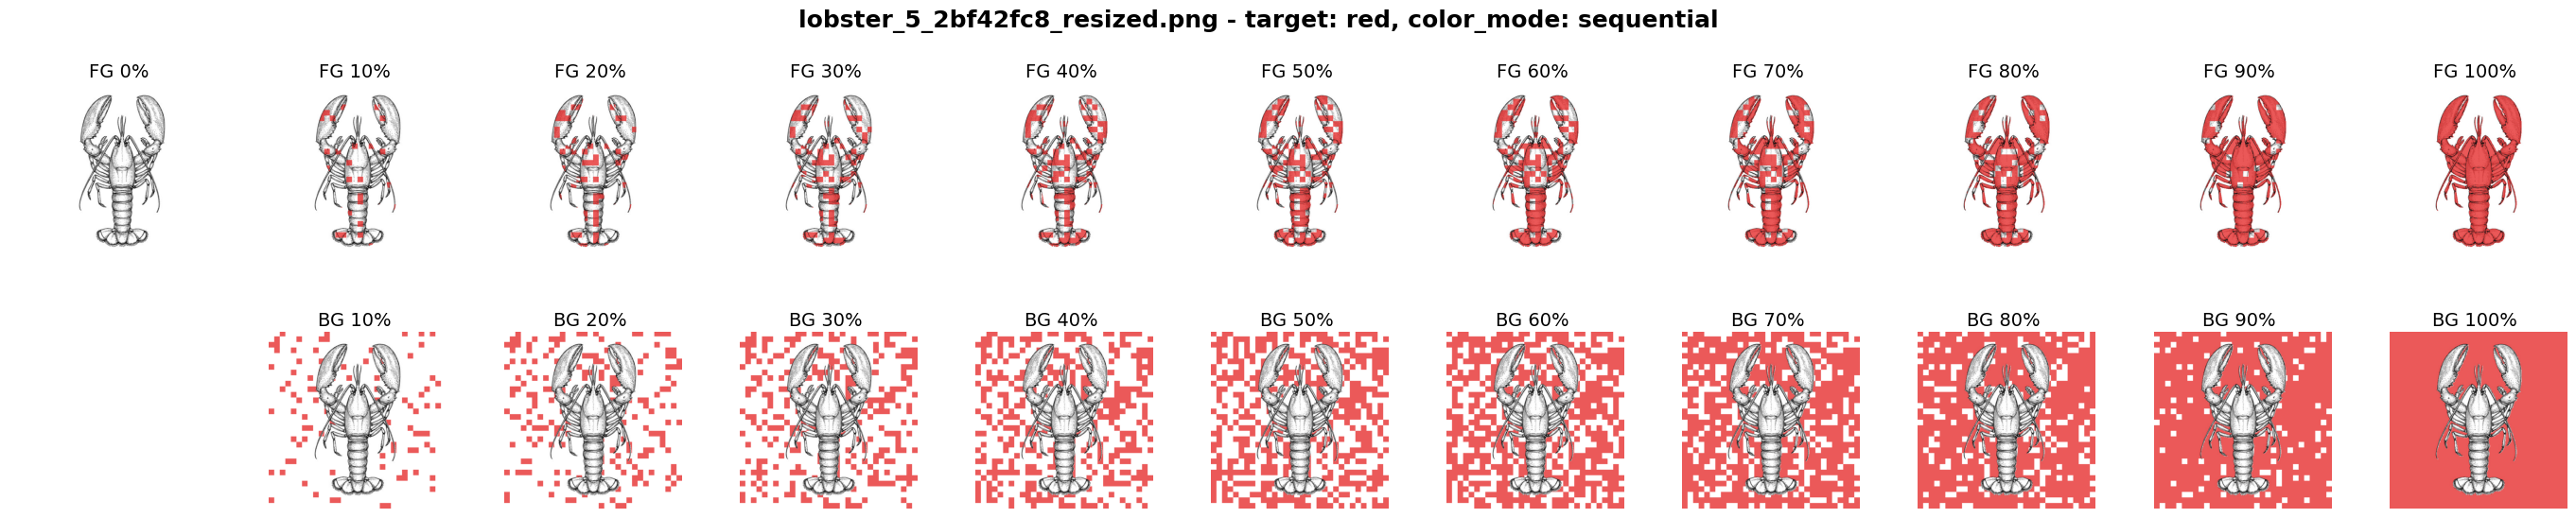

In [16]:
for idx, row in df.head(5).iterrows():
    for color_mode in coloring_modes:
        show_variants_grid(row['image_path'], row['correct_answer'], OUT_COLOR, color_mode=color_mode, pct_range=ten_increase)

## 2.4. Evaluate open-weight models on recolored image variants

In [ ]:
"""# Main evaluation of color outline variants for BOTH independent and sequential coloring
preds = []

print("Running outline variant evaluation...")

for _, row in tqdm(df.iterrows(), total=len(df), desc="Evaluating objects"):
    image_path = row["image_path"]
    object_name = row["object"]
    target_color = row["correct_answer"]
    
    # Collect all variant image paths for this color
    variants = collect_variants_for(image_path, target_color, out_root=color_outlines)
    if not variants:
        continue

    # Build a dataframe for all variants of this image
    df_variants = pd.DataFrame({
        "image_path": [str(p) for p in variants],
        "image_variant": [variant_label(p) for p in variants],
        "object": [object_name] * len(variants),
        "correct_answer": [target_color] * len(variants)
    })

    # Run both "most" and "this" question types on all variants
    df_eval = run_vlm_evaluation(
        df=df_variants,
        processor=processor,
        model=model,
        device=device,
        batch_size=1,
        mode="both",
        return_probs=True   
    )
    df_eval = df_eval[["object", "image_variant", "correct_answer", "pred_color_most", "pred_color_this", "prob_correct_most", "prob_correct_this"]]
    preds.append(df_eval)

    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    gc.collect()

pred_color_df = pd.concat(preds, ignore_index=True)

out_path = data_folder / "outline_results.csv"
pred_color_df.to_csv(out_path, index=False)
print(f"Saved combined outline evaluation results to {out_path}")
display(pred_color_df.head(10))"""

Running outline variant evaluation...


Evaluating objects:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# Main evaluation of color outline variants only for sequential coloring and 'this' prompt
preds = []

print("Running outline variant evaluation...")

for _, row in tqdm(df.iterrows(), total=len(df), desc="Evaluating objects", position=0):
    image_path = row["image_path"]
    object_name = row["object"]
    target_color = row["correct_answer"]
    
    # Collect all variant image paths for this color
    variants = collect_variants_for(image_path, target_color, out_root=OUT_COLOR)
    if not variants:
        continue

    # Build a dataframe for all variants of this image
    df_variants = pd.DataFrame({
        "image_path": [str(p) for p in variants],
        "image_variant": [variant_label(p) for p in variants],
        "object": [object_name] * len(variants),
        "correct_answer": [target_color] * len(variants)
    })

    # Run both "most" and "this" question types on all variants
    df_eval = run_vlm_evaluation(
        df=df_variants,
        processor=processor,
        model=model,
        device=device,
        batch_size=1,
        mode="this",
        return_probs=True   
    )
    df_eval = df_eval[["object", "image_variant", "correct_answer", "pred_color_this", "prob_correct_this"]]
    preds.append(df_eval)

    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    gc.collect()

pred_df = pd.concat(preds, ignore_index=True)

out_path = DATA / "outline_results_dummy.csv"
pred_df.to_csv(out_path, index=False)
print(f"Saved combined outline evaluation results to {out_path}")
display(pred_df.head(10))

Running outline variant evaluation...


Evaluating objects: 100%|██████████| 215/215 [4:31:08<00:00, 75.67s/it]  


NameError: name 'data_folder' is not defined

In [17]:
# Checkpoint: Load evaluation
# Results for model prior with black-white image given
pred_color_df = pd.read_csv(DATA / "outline_results.csv")
display(pred_color_df)

# Results for dummy model prior
pred_color_df_dummy = pd.read_csv(DATA / "outline_results_dummy.csv")
display(pred_color_df_dummy)

,object,image_variant,correct_answer,pred_color_this,prob_correct_this
0,sunflower,BG 0% (seq),yellow,white,0.001710
1,sunflower,BG 1% (seq),yellow,white,0.042755
2,sunflower,BG 2% (seq),yellow,white,0.042511
3,sunflower,BG 3% (seq),yellow,white,0.043091
4,sunflower,BG 4% (seq),yellow,white,0.042267
...,...,...,...,...,...
4435,digital watch,FG 60% (seq),black,black,0.863281
4436,digital watch,FG 70% (seq),black,black,0.888184
4437,digital watch,FG 80% (seq),black,black,0.912598
4438,digital watch,FG 90% (seq),black,black,0.922852


,object,image_variant,correct_answer,pred_color_this,prob_correct_this
0,sunflower,BG 0% (seq),yellow,white,0.000854
1,sunflower,BG 1% (seq),yellow,white,0.160889
2,sunflower,BG 2% (seq),yellow,white,0.195923
3,sunflower,BG 3% (seq),yellow,white,0.237061
4,sunflower,BG 4% (seq),yellow,white,0.228394
...,...,...,...,...,...
8595,tow truck,FG 60% (seq),red,red,0.897461
8596,tow truck,FG 70% (seq),red,red,0.906250
8597,tow truck,FG 80% (seq),red,red,0.922852
8598,tow truck,FG 90% (seq),red,red,0.939941


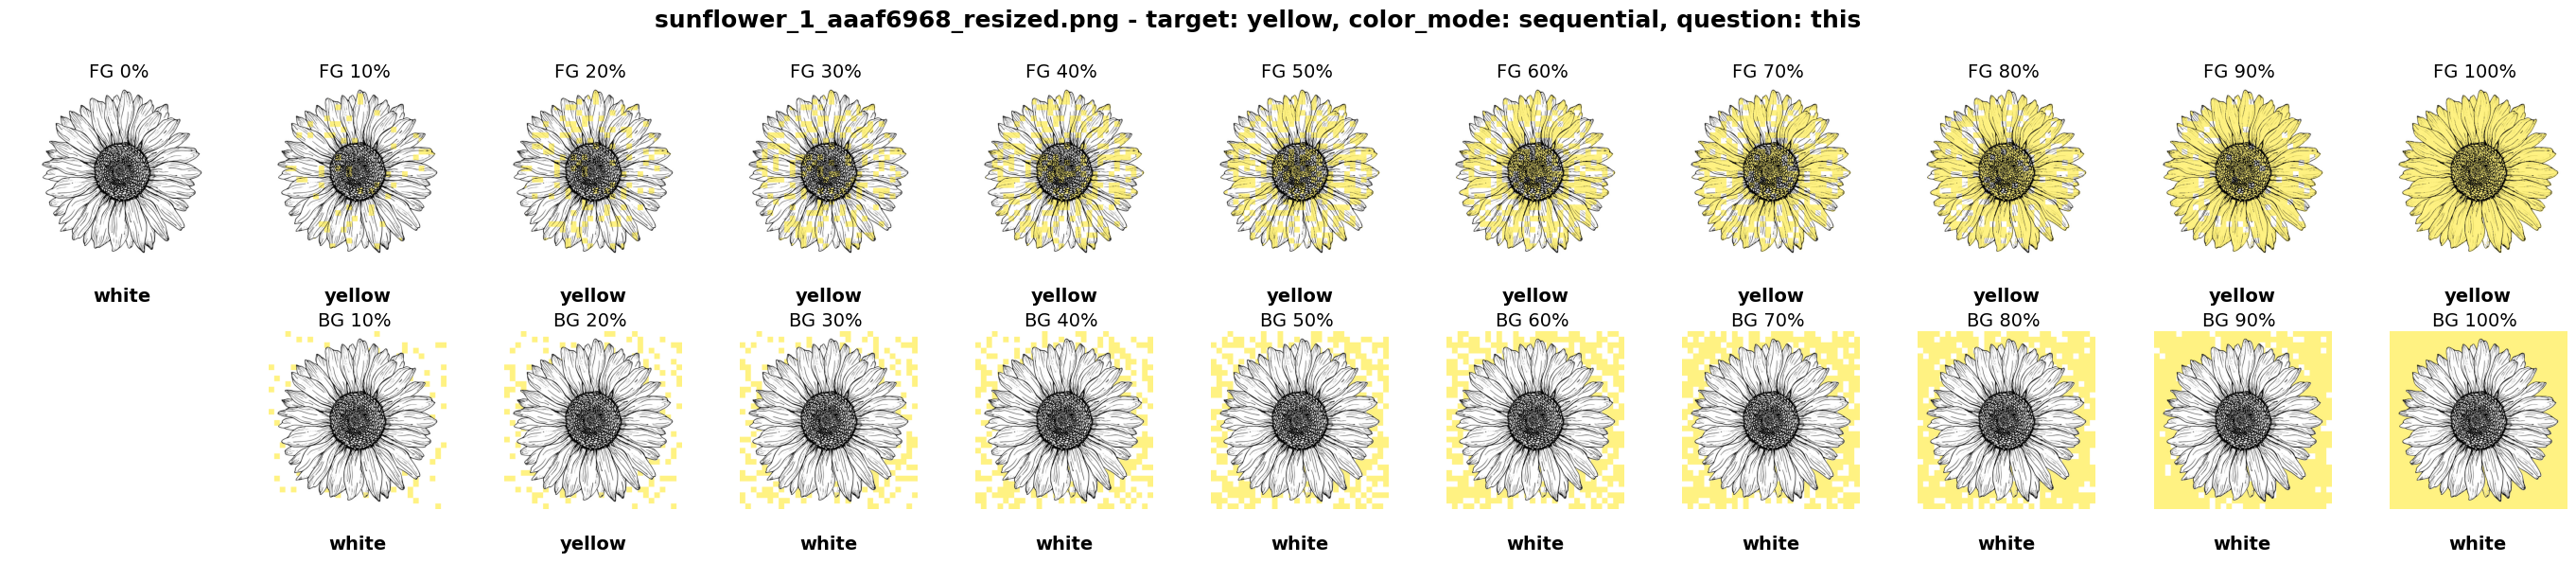

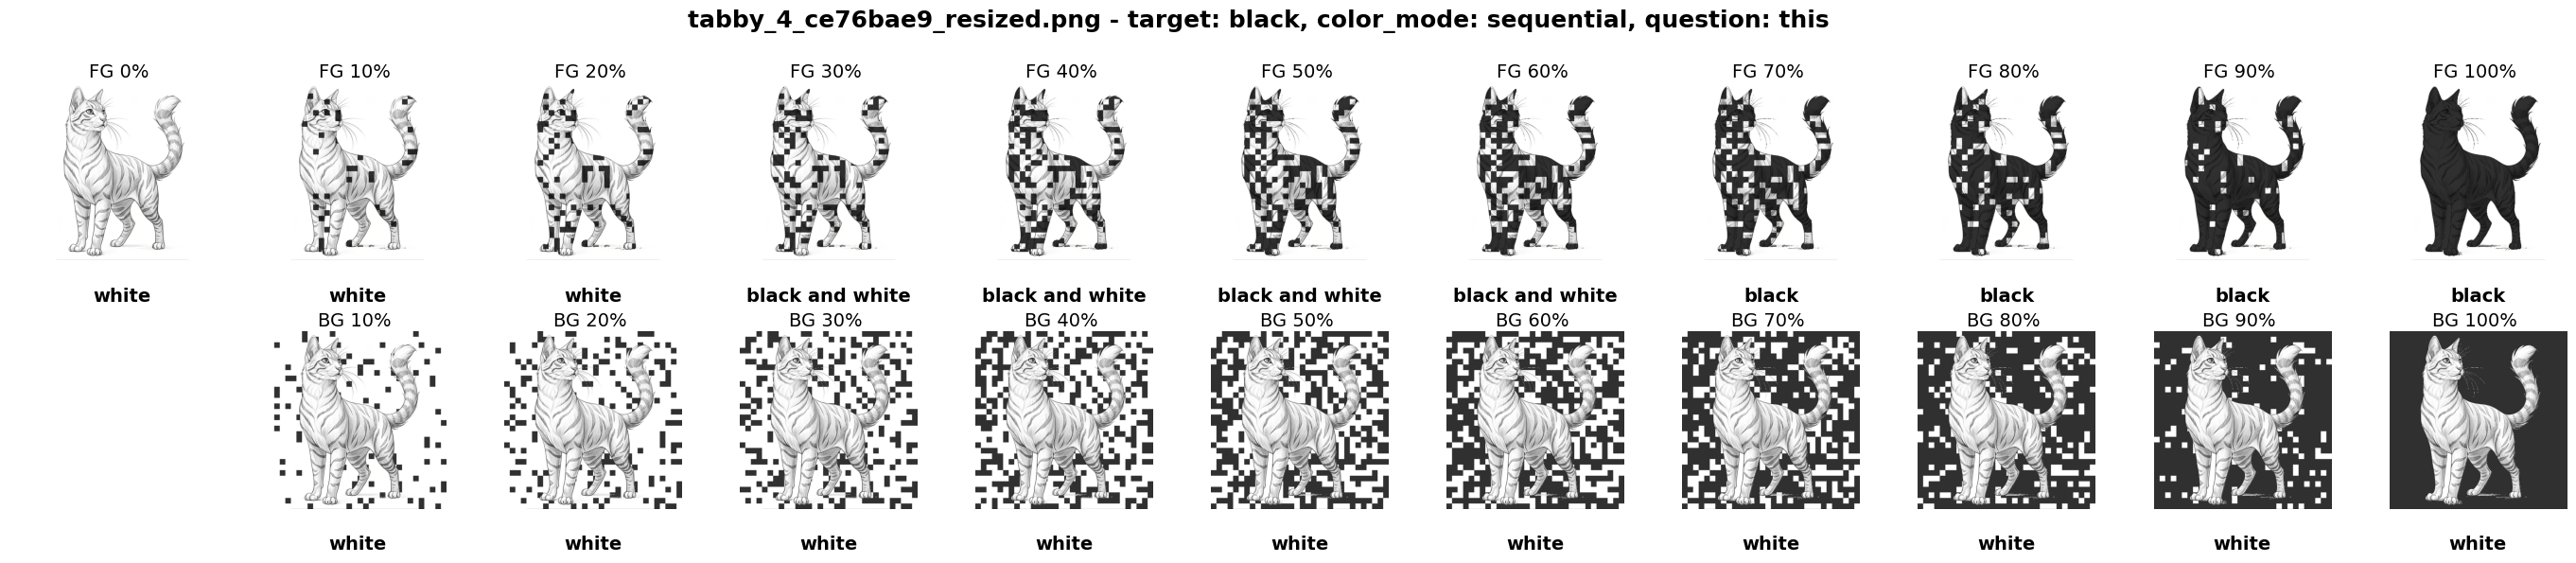

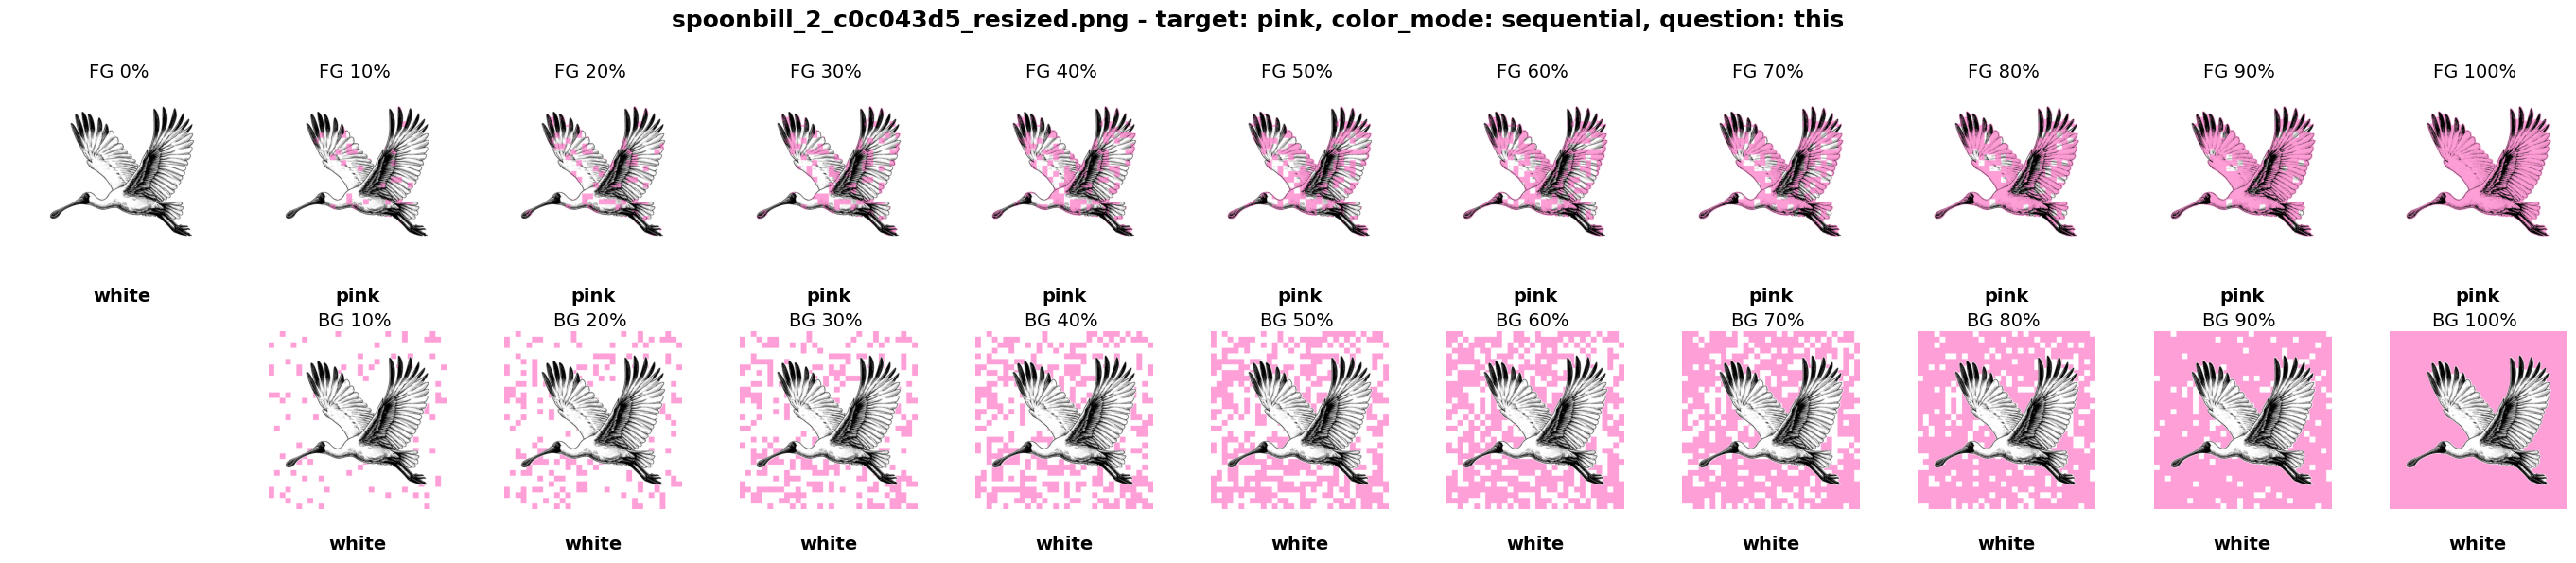

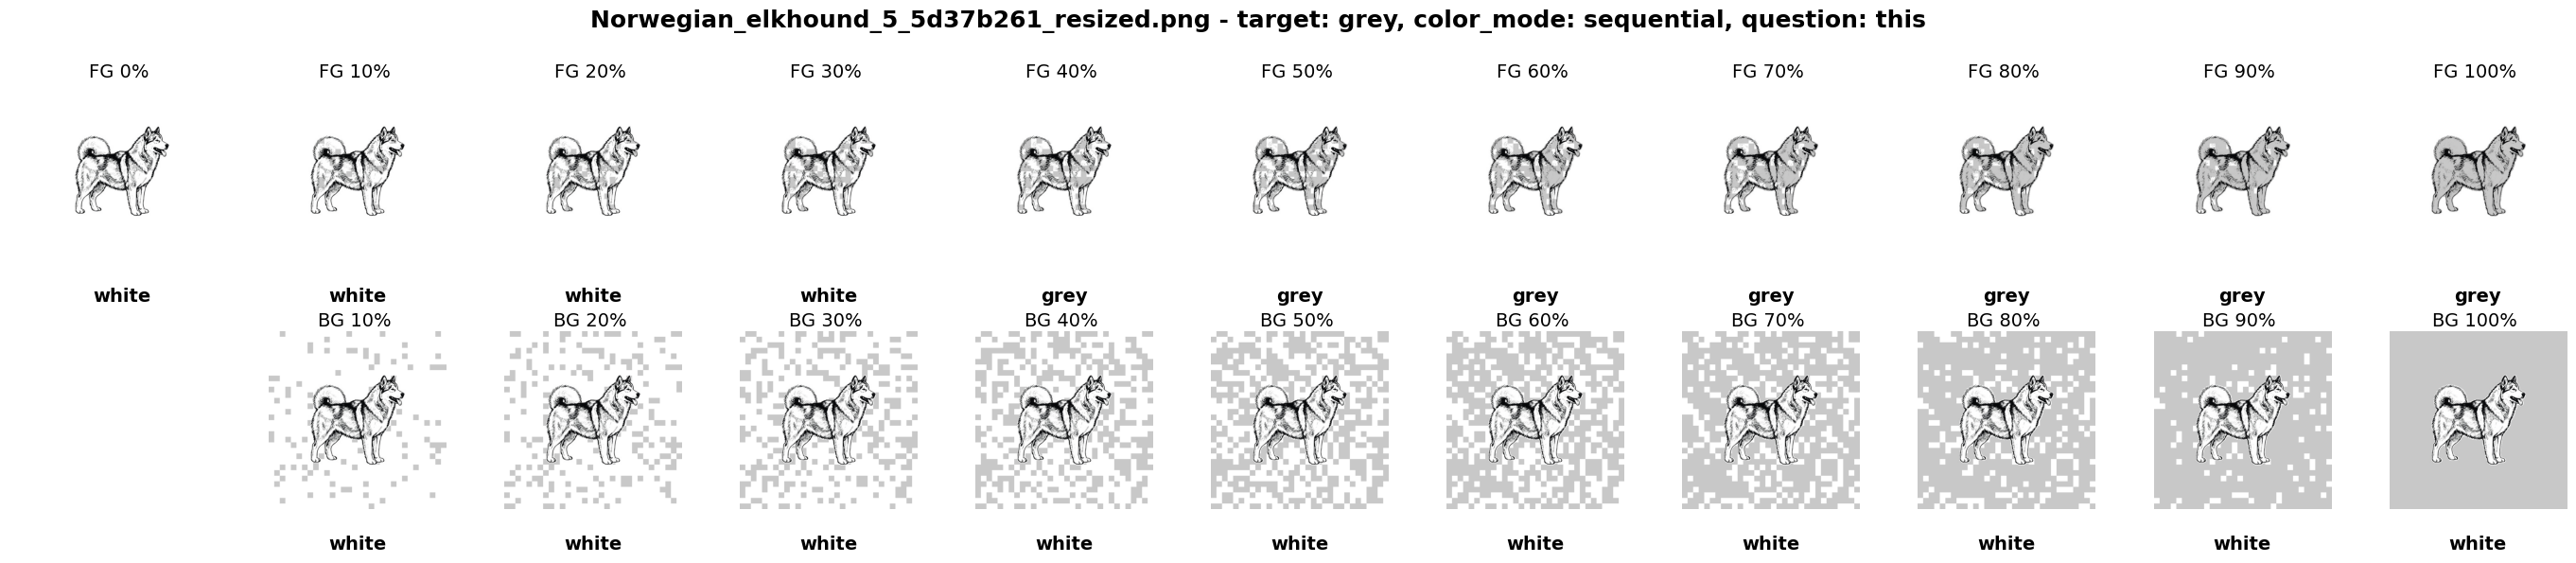

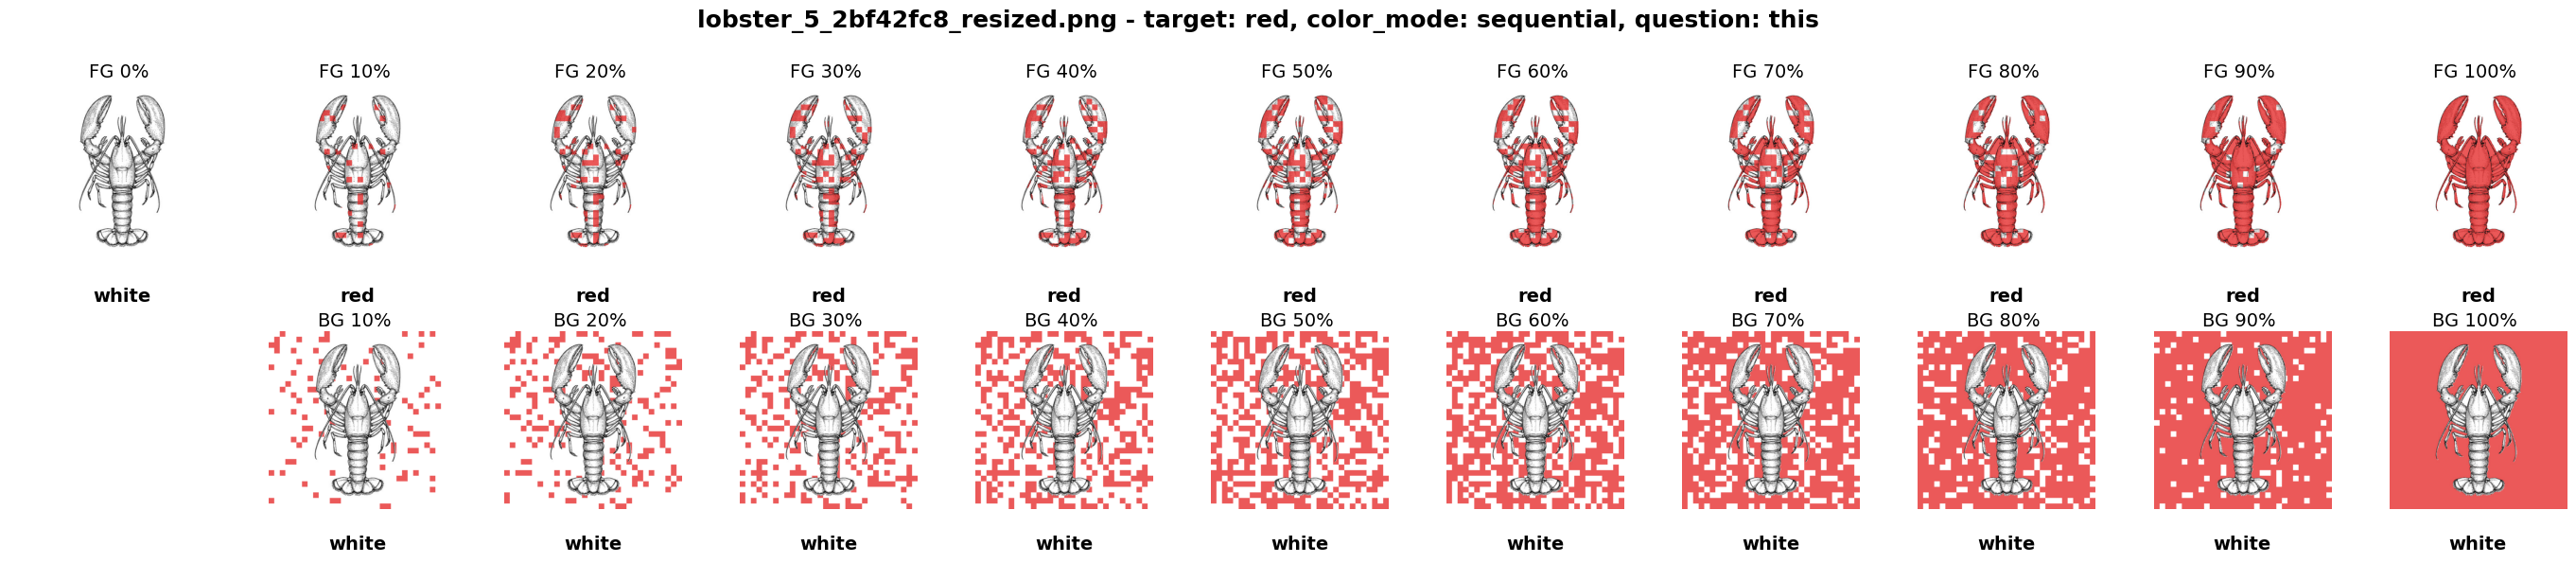

In [19]:
for idx, row in df.head(5).iterrows():
    for color_mode in coloring_modes:
        show_variants_grid(row["image_path"], row['correct_answer'], OUT_COLOR, pred_color_df_dummy, question="this", color_mode="sequential", pct_range=ten_increase)
        #show_variants_grid(row["image_path"], row['correct_answer'], color_outlines, pred_color_df, question="most", color_mode=color_mode, pct_range=compact)
    

In [18]:
modes = ["seq"] #"ind"]

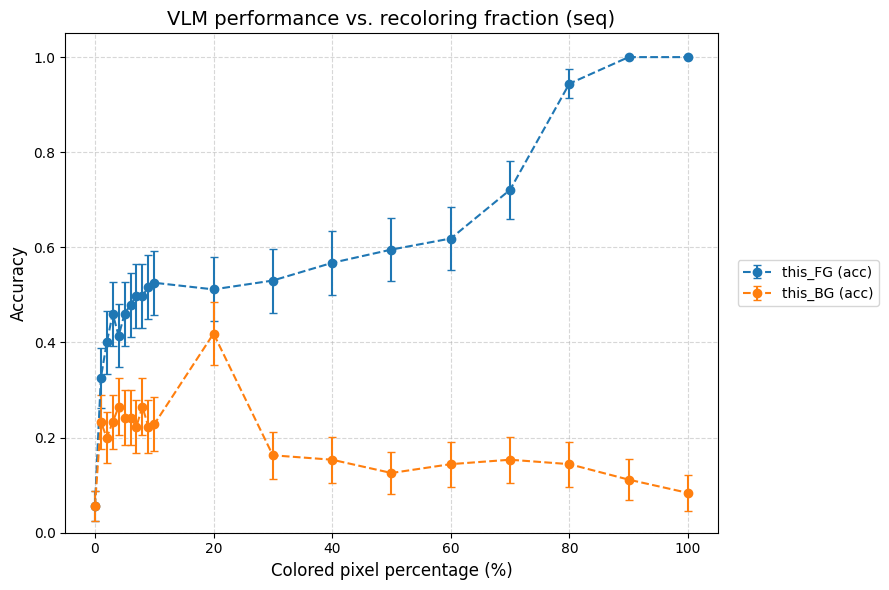

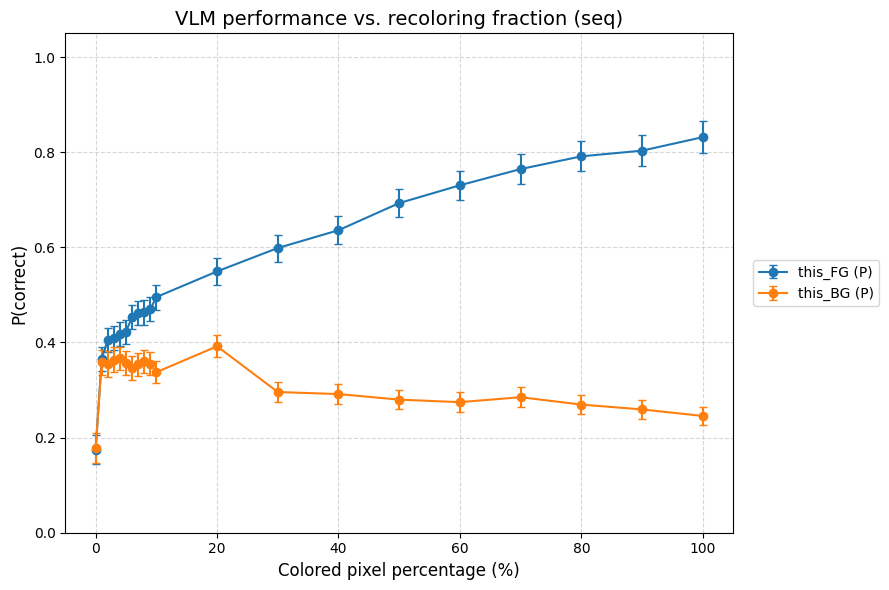

In [20]:
# Plot full range
for mode in modes:
    plot_vlm_performance(pred_color_df_dummy, show_accuracy=True, ci=True, show_probability=False, color_mode=mode)
    plot_vlm_performance(pred_color_df_dummy, show_accuracy=False, ci=True, show_probability=True, color_mode=mode)

## 2.5. Evaluate GPT on recolored image variants

In [23]:
# Load segmented images dataframe again for GPT
df_GPT = pd.read_csv(DATA / "segmented_images.csv")
display(df_GPT)

,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response,score,watermark,num_objects,cv_mask_path,sam_mask_path
0,['yellow'],purple,sunflower,https://thumbs.dreamstime.com/b/black-outline-...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
1,"['brown', 'black', 'orange']",green,tabby,https://img.recraft.ai/5P-WlUIGI2MwJC2v_JyrGkp...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
2,"['pink', 'white']",green,spoonbill,https://img.freepik.com/premium-vector/drawing...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
3,['white'],green,Samoyed,https://img.freepik.com/premium-photo/black-wh...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
4,"['grey', 'black']",red,Norwegian elkhound,https://t3.ftcdn.net/jpg/16/85/30/00/360_F_168...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
...,...,...,...,...,...,...,...,...,...,...,...
215,"['gold', 'silver']",green,crown,https://i.pinimg.com/736x/32/52/35/325235d85fb...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",42.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
216,"['orange', 'white']",purple,pill bottle,https://media.istockphoto.com/id/470313936/vec...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",35.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
217,['black'],pink,dial telephone,https://png.pngtree.com/png-clipart/20230811/o...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",35.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
218,['black'],pink,digital watch,https://img.freepik.com/premium-vector/digital...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",34.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...


In [56]:
# Initialize GPTColorPriors
priors_GPT = GPTColorPriors(model_name="gpt-4o", data_folder=DATA)

# Generate GPT color priors
priors_df_GPT = priors_GPT.get_model_color_priors(df_GPT.head(10))

GPT Priors (gpt-4o): 100%|██████████| 10/10 [00:25<00:00,  2.58s/it]

Saved GPT color priors → /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/color_priors_gpt-4o.csv


In [57]:
priors_df_GPT

,object,correct_answer,dummy_priors,image_priors
0,sunflower,['yellow'],"[yellow, brown, green]",[a detailed black and white sunflower illustra...
1,tabby,"['brown', 'black', 'orange']","[brown, grey, orange]",[a detailed sketch of a striped cat]
2,spoonbill,"['pink', 'white']","[white, pink, red]","[illustration of a flying bird with a long, fl..."
3,Samoyed,['white'],"[white, cream, biscuit]","[a smiling, fluffy dog illustration]"
4,Norwegian elkhound,"['grey', 'black']","[grey, black, white]",[a detailed illustration of a standing dog]
5,lobster,['red'],"[red, blue, yellow]",[detailed illustration of a lobster]
6,hare,"['white', 'brown']","[brown, white, grey]",[a sketch of a sitting rabbit]
7,car wheel,"['silver', 'black']","[silver, black, grey]",[a detailed illustration of a car wheel and tire]
8,bullfrog,['green'],"[green, brown, olive]",[detailed illustration of a frog]
9,dandelion,['yellow'],"[yellow, white, green]",[a detailed pencil drawing of a dandelion plant]


In [ ]:


priors_df["primary_color"], priors_df["prior_changed"] = \
    priors.pick_primary_color(priors_df, column="dummy_priors")

priors_df = priors_df.dropna(subset=["primary_color"])
